In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import scipy.stats

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [5]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
sim = InteractiveContext(path, setup=False)

In [6]:
sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2023
                                  }
                              }
                          }
                        )
sim.setup()

2023-10-17 09:29:07.404 | INFO     | simulation_1-artifact_manager:67 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-10-17 09:29:07.405 | INFO     | simulation_1-artifact_manager:68 - Artifact base filter terms are ['draw == 0'].
2023-10-17 09:29:07.408 | INFO     | simulation_1-artifact_manager:69 - Artifact additional filter terms are None.


In [7]:
pop0 = sim.get_population()
pop0.head()

,tracked,exit_time,alive,age,location,sex,entrance_time,years_of_life_lost,cause_of_death,previous_ischemic_stroke,...,polypill,ldlc_therapeutic_inertia_propensity,lifestyle,sbp_therapeutic_inertia_propensity,sbp_medication,ldlc_medication,sbp_multiplier,last_fpg_test_date,scheduled_date,visit_type
0,True,NaT,alive,7.004023,Alabama,Female,2022-12-04,0.0,not_dead,,...,cat2,0.919800,NaT,0.097739,no_treatment,no_treatment,1.0,NaT,NaT,none
1,True,NaT,alive,66.517368,Alabama,Male,2022-12-04,0.0,not_dead,,...,cat2,0.823712,NaT,0.828911,no_treatment,medium_intensity,1.0,NaT,NaT,none
2,True,NaT,alive,40.859520,Alabama,Male,2022-12-04,0.0,not_dead,,...,cat2,0.195054,NaT,0.166866,one_drug_half_dose_efficacy,no_treatment,1.0,NaT,NaT,none
3,True,NaT,alive,14.248124,Alabama,Female,2022-12-04,0.0,not_dead,,...,cat2,0.575587,NaT,0.511069,no_treatment,no_treatment,1.0,NaT,NaT,none
4,True,NaT,alive,41.302116,Alabama,Male,2022-12-04,0.0,not_dead,,...,cat2,0.584597,NaT,0.341131,no_treatment,no_treatment,1.0,2021-06-21 03:18:08.113444256,NaT,none


In [8]:
#pop0.columns

In [9]:
#sim.list_values()

In [10]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                  ], axis=1)
data1.head()

,tracked,exit_time,alive,age,location,sex,entrance_time,years_of_life_lost,cause_of_death,previous_ischemic_stroke,...,sbp_medication,ldlc_medication,sbp_multiplier,last_fpg_test_date,scheduled_date,visit_type,high_ldl,high_sbp,high_bmi,high_fpg
0,True,NaT,alive,7.004023,Alabama,Female,2022-12-04,0.0,not_dead,,...,no_treatment,no_treatment,1.0,NaT,NaT,none,0.000000,50.000000,5.000000,1.000000
1,True,NaT,alive,66.517368,Alabama,Male,2022-12-04,0.0,not_dead,,...,no_treatment,medium_intensity,1.0,NaT,NaT,none,2.030733,150.585335,21.683348,9.353520
2,True,NaT,alive,40.859520,Alabama,Male,2022-12-04,0.0,not_dead,,...,one_drug_half_dose_efficacy,no_treatment,1.0,NaT,NaT,none,2.245140,135.545603,24.140242,9.447039
3,True,NaT,alive,14.248124,Alabama,Female,2022-12-04,0.0,not_dead,,...,no_treatment,no_treatment,1.0,NaT,NaT,none,0.000000,50.000000,5.000000,1.000000
4,True,NaT,alive,41.302116,Alabama,Male,2022-12-04,0.0,not_dead,,...,no_treatment,no_treatment,1.0,2021-06-21 03:18:08.113444256,NaT,none,2.692781,104.193773,37.344203,5.037473


In [11]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

## Testing For Exposure Values in Highest Age Group

In [12]:
data_old = data1.loc[(data1.age_start > 90)]


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  3.,  3.,  3.,  2.,  7.,  4.,  7.,  6.,
         3.,  7.,  5., 10.,  5.,  5.,  3.,  7.,  4.,  4.,  2.,  1.,  0.,
         2.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 5.        ,  5.75208294,  6.50416588,  7.25624883,  8.00833177,
         8.76041471,  9.51249765, 10.2645806 , 11.01666354, 11.76874648,
        12.52082942, 13.27291237, 14.02499531, 14.77707825, 15.52916119,
        16.28124414, 17.03332708, 17.78541002, 18.53749296, 19.28957591,
        20.04165885, 20.79374179, 21.54582473, 22.29790768, 23.04999062,
        23.80207356, 24.5541565 , 25.30623944, 26.05832239, 26.81040533,
        27.56248827, 28.31457121, 29.06665416, 29.8187371 , 30.57082004,
        31.32290298, 32.07498593, 32.82706887, 33.57915181, 34.33123475,
        35.0833177 , 35.83540064, 36.58748358, 37.33956652, 38.09164947,
        38.84373241, 39.59581535, 40.34789829, 41.09998124,

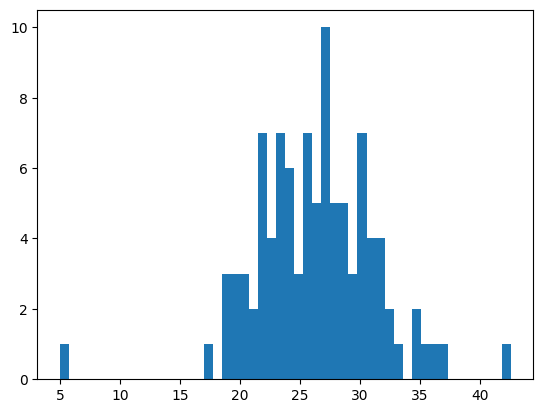

In [18]:
plt.hist(data_old.high_bmi, bins=50)

In [15]:
data_old

,tracked,exit_time,alive,age,location,sex,entrance_time,years_of_life_lost,cause_of_death,previous_ischemic_stroke,...,ldlc_medication,sbp_multiplier,last_fpg_test_date,scheduled_date,visit_type,high_ldl,high_sbp,high_bmi,high_fpg,age_start
275,True,NaT,alive,97.654584,Alabama,Female,2022-12-04,0.0,not_dead,,...,no_treatment,1.120,NaT,NaT,none,3.343039,149.557519,24.353459,4.148422,95.0
311,True,NaT,alive,95.538054,Alabama,Female,2022-12-04,0.0,not_dead,,...,no_treatment,1.120,2020-02-15 02:14:55.375164432,NaT,none,2.436003,108.689636,31.065047,6.092926,95.0
530,True,NaT,alive,102.619930,Alabama,Female,2022-12-04,0.0,not_dead,,...,low_intensity,1.051,2021-01-09 08:50:11.676027344,NaT,none,2.262449,167.845195,29.285548,7.540543,100.0
2320,True,NaT,alive,104.146978,Alabama,Female,2022-12-04,0.0,not_dead,,...,medium_intensity,1.120,2021-10-25 20:40:37.802610736,NaT,none,1.839739,115.520124,25.487455,4.588543,100.0
2352,True,NaT,alive,106.358444,Alabama,Female,2022-12-04,0.0,not_dead,,...,low_intensity,1.000,NaT,NaT,none,1.806660,120.143889,23.205314,5.524351,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48011,True,NaT,alive,98.769289,Alabama,Male,2022-12-04,0.0,not_dead,,...,low_intensity,1.051,NaT,NaT,none,2.492551,146.449886,20.254006,7.077211,95.0
48343,True,NaT,alive,97.522457,Alabama,Female,2022-12-04,0.0,not_dead,,...,no_treatment,1.120,NaT,NaT,none,3.301642,183.845180,30.745548,5.631391,95.0
48393,True,NaT,alive,106.513757,Alabama,Female,2022-12-04,0.0,not_dead,,...,medium_intensity,1.051,2022-06-10 12:18:38.321447738,NaT,none,4.068998,156.200455,32.527714,5.085688,105.0
48969,True,NaT,alive,100.426602,Alabama,Male,2022-12-04,0.0,not_dead,,...,no_treatment,1.000,NaT,NaT,none,3.460612,156.962391,24.168673,4.274891,100.0


## Lastly, going to test this again after some time and see how it holds up! 

In [19]:
sim_data = pd.DataFrame()
for step in list(range(0,25)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                       ],axis=1)
    data_t['step'] = step
    print(step)
    sim_data = pd.concat([sim_data, data_t])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


(array([1., 3., 2., 3., 3., 2., 2., 5., 5., 5., 3., 4., 4., 7., 5., 7., 6.,
        5., 4., 4., 3., 1., 2., 4., 3., 5., 3., 5., 5., 2., 1., 1., 1., 1.,
        2., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 2.]),
 array([18.65451029, 19.15856887, 19.66262744, 20.16668602, 20.67074459,
        21.17480317, 21.67886174, 22.18292032, 22.68697889, 23.19103747,
        23.69509604, 24.19915461, 24.70321319, 25.20727176, 25.71133034,
        26.21538891, 26.71944749, 27.22350606, 27.72756464, 28.23162321,
        28.73568179, 29.23974036, 29.74379894, 30.24785751, 30.75191609,
        31.25597466, 31.76003324, 32.26409181, 32.76815039, 33.27220896,
        33.77626754, 34.28032611, 34.78438469, 35.28844326, 35.79250184,
        36.29656041, 36.80061899, 37.30467756, 37.80873613, 38.31279471,
        38.81685328, 39.32091186, 39.82497043, 40.32902901, 40.83308758,
        41.33714616, 41.84120473, 42.34526331, 42.84932188, 43.35338046,
        43.85743903]),
 <BarContainer object

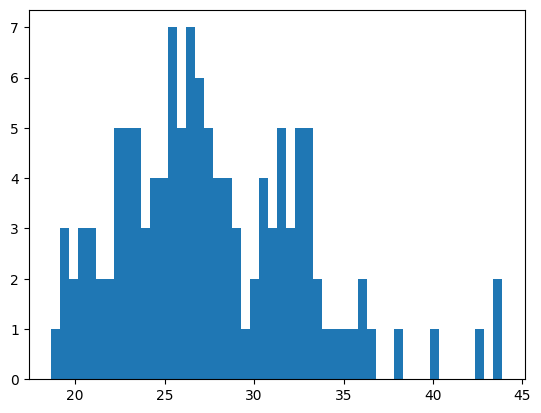

In [20]:
last_step = sim_data.loc[(sim_data.step==24) & (sim_data.age > 25) & (sim_data.alive == 'alive')]
last_step['age_start'] = ((last_step.age/5).astype(int) * 5).astype(float)
last_step_old = last_step.loc[(last_step.age_start > 90)]
plt.hist(last_step_old.high_bmi, bins=50)